# 多空股票基金策略

By Delaney Granizo-Mackenzie

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [https://github.com/quantopian/research_public](https://github.com/quantopian/research_public)



多空股票是指在股票市场上既做多又做空的策略。这是一个相当笼统的说法，但随着时间的推移，它已发展为一个特定的策略家族。这些策略使用某种模型对市场中的所有股票进行排序。然后做多(买入)排名靠前的$n$只股票，做空(卖出)排名靠后的$n$只股票，同时在做多和做空头寸之间保持相等的美元交易量。这在统计上具有稳健的优势，因为通过对股票进行排名并进入数百或数千个头寸，你是在自己的排名模型上押了很多注，而不是押了几个高风险的注。你也可以单纯地把赌注押在你的排名体系的质量上，因为等量的美元多头和空头头寸确保了该策略将保持市场中性(不受市场波动影响)。

## 排名方案

排名方案是任何可以为每只股票分配一个数字的模型，这个数字越大越好或越差。例子可以是价值因素、技术指标、定价模型，或者以上所有因素的组合。按因素排序的宇宙课程将更详细地介绍排序方案。排名方案是任何多空股票策略的秘密武器，因此开发它们并非易事。

## 在排名方案上下注

一旦我们确定了一个排名方案，我们希望能够从中获利。我们通过向排名靠前的公司投入等量的资金，而向排名靠后的公司投入等量的资金。这确保了该战略将赚钱比例与质量的排名，并将是中性的市场。

### 做多篮子和做空篮子

如果你正在对$m$只股票进行排名，有$d$美元要投资，你持有的总目标头寸数为$2n$，那么长篮子和短篮子的创建如下。对于排名中第$1, \dots, n$位的每一只股票，出售该权益的$\frac{1}{2n} * d$。对于排名中第$m - n, \dots, m$位的每一只股票，出售该权益的$\frac{1}{2n} * d$。

#### 价格摩擦

由于股票价格并不总是均分$\frac{1}{2n} * d$，而且股票必须以整数数量购买，因此会有一些不精确，算法应该尽可能接近这个数字。大多数算法在执行过程中都会有一些杠杆作用，所以购买略高于$\frac{1}{2n} * d$的股票是可以的。然而，这确实会在低资本数额时造成一些摩擦。对于运行$d = 100000$和$n = 500$的策略，我们可以看到
$$\frac{1}{2n} * d = \frac{1}{1000} * 100000 = 100$$
这将给昂贵的股票带来大问题，并导致算法过度杠杆化。这可以通过减少股票交易或增加资本$d$来缓解。幸运的是，多空股票策略的资本充足率往往很高，因此在大多数情况下，投资者可以投资的资金数量没有上限。有关算法容量的更多信息，请参阅发布时的算法容量讲座。

### 回报来自排名差价

多空股票策略的回报取决于该排名对高回报和低回报的分配。要了解这是如何工作的，请考虑这个假设的示例。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# We'll generate a random factor
current_factor_values = np.random.normal(0, 1, 10000)
equity_names = ['Equity ' + str(x) for x in range(10000)]
# Put it into a dataframe
factor_data = pd.Series(current_factor_values, index = equity_names)
factor_data = pd.DataFrame(factor_data, columns=['Factor Value'])
# Take a look at the dataframe
factor_data.head(10)

,Factor Value
Equity 0,-1.195496
Equity 1,-2.818511
Equity 2,1.099218
Equity 3,-0.216370
Equity 4,-1.525432
Equity 5,0.891385
Equity 6,-0.474501
Equity 7,2.154706
Equity 8,0.530437
Equity 9,0.361507


In [3]:
# Now let's say our future returns are dependent on our factor values
future_returns = current_factor_values + np.random.normal(0, 1, 10000)

returns_data = pd.Series(future_returns, index=equity_names)
returns_data = pd.DataFrame(returns_data, columns=['Returns'])
# Put both the factor values and returns into one dataframe
data = returns_data.join(factor_data)
# Take a look
data.head(10)

,Returns,Factor Value
Equity 0,-2.761964,-1.195496
Equity 1,-2.874584,-2.818511
Equity 2,0.397822,1.099218
Equity 3,-0.265639,-0.216370
Equity 4,-2.841123,-1.525432
Equity 5,0.985490,0.891385
Equity 6,-0.276824,-0.474501
Equity 7,1.266305,2.154706
Equity 8,-0.105983,0.530437
Equity 9,-1.263717,0.361507


现在我们有了要素价值和回报，我们可以看到如果我们根据要素价值对股票进行排序，然后进入多头和空头头寸会发生什么。

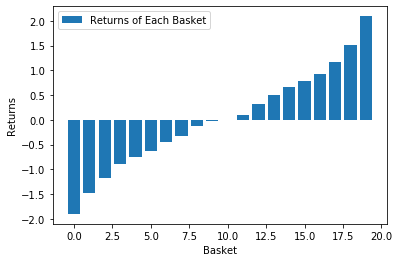

In [8]:
# Rank the equities
ranked_data = data.sort_values('Factor Value')

# Compute the returns of each basket
# Baskets of size 500, so we create an empty array of shape (10000/500)
number_of_baskets = int(10000/500)
basket_returns = np.zeros(number_of_baskets)

for i in range(number_of_baskets):
    start = i * 500
    end = i * 500 + 500
    basket_returns[i] = ranked_data[start:end]['Returns'].mean()

# Plot the returns of each basket
plt.bar(range(number_of_baskets), basket_returns)
plt.ylabel('Returns')
plt.xlabel('Basket')
plt.legend(['Returns of Each Basket'])

如果我们做多顶部的篮子做空底部的篮子，我们来计算回报。

In [9]:
basket_returns[number_of_baskets-1] - basket_returns[0]

3.9911420232456774

### 市场中立性是内在的

基于排名的传播赚钱的好处是它不受市场行为的影响。

In [12]:
# We'll generate a random factor
current_factor_values = np.random.normal(0, 1, 10000)
equity_names = ['Equity ' + str(x) for x in range(10000)]
# Put it into a dataframe
factor_data = pd.Series(current_factor_values, index = equity_names)
factor_data = pd.DataFrame(factor_data, columns=['Factor Value'])

# Now let's say our future returns are dependent on our factor values
future_returns = -10 + current_factor_values + np.random.normal(0, 1, 10000)

returns_data = pd.Series(future_returns, index=equity_names)
returns_data = pd.DataFrame(returns_data, columns=['Returns'])
# Put both the factor values and returns into one dataframe
data = returns_data.join(factor_data)

# Rank the equities
ranked_data = data.sort_values('Factor Value')

# Compute the returns of each basket
# Baskets of size 500, so we create an empty array of shape (10000/500
number_of_baskets = int(10000/500)
basket_returns = np.zeros(number_of_baskets)

for i in range(number_of_baskets):
    start = i * 500
    end = i * 500 + 500 
    basket_returns[i] = ranked_data[start:end]['Returns'].mean()

basket_returns[number_of_baskets-1] - basket_returns[0]

4.17899357010196

## 排名方案的选择和评估

排名机制是多空股票策略的优势所在，也是最关键的组成部分。选择一个好的排名方案是全部的技巧，没有简单的答案。一个好的起点是选择现有的已知技术，看看是否可以稍微修改它们以获得更高的回报。更多排名方案建设的信息可以在下面列出的笔记本中找到。

在研究你的排名方案时，确定你的排名方案是否真的能预测未来的回报是很重要的。这可以通过斯皮尔曼等级相关来实现

关于排名方案的构建和评估的信息可在以下讲座中获得:
* [Universe Selection](https://www.quantopian.com/lectures/universe-selection)
* [Spearman Rank Correlation](https://www.quantopian.com/lectures/spearman-rank-correlation)
* [Factor Analysis](https://www.quantopian.com/lectures/factor-analysis)

## 多-空策略是一种模块化策略

要执行多空股票，你实际上只需要确定排名方案。之后的一切都是机械的。一旦你有了一个多空股票策略，你就可以在不同的排名方案中进行互换，而把其他的都保留下来。这是一种非常方便的方法，可以快速遍历您的想法，而不必担心每次都要调整代码。

排名方案几乎可以来自任何模型。它不必是一个基于价值的因素模型，它可以是一个机器学习技术，预测一个月前的回报，并根据它进行排名。

我们将发布长-短算法的样本，以配合这个笔记本。请继续关注。

## 额外的注意事项

### 调整频率

每一个排名系统都可以预测在一个稍微不同的时间段内的回报。基于价格的均值回归可以预测几天，而基于价值的因素模型可以预测几个月。重要的是要确定你的模型应该预测的时间范围，并在执行策略之前进行统计验证。你确实想通过优化重新标记的频率来过度拟合，你将不可避免地发现一个比其他的随机更好，但不是必要的，因为你的模型中有任何东西。

一旦你确定了你的排名计划可以预测的时间范围，试着在这个频率上重新平衡，这样你就可以充分利用你的模型。

 
### 资本的能力

每一种策略在停止盈利之前，都有它所能交易的资本的最小和最大值。我们将发布一个完整的笔记本，讨论这些概念，但同时考虑以下几点。

### 股票交易数量

#### 交易成本

交易许多股票将导致高交易成本。假设你想购买$1000$股股票，那么每一次再平衡就会产生数千美元的成本。你的资本基础必须足够高，交易成本占你的战略产生的回报的一小部分。假设你运营$100000$美元，每个月赚$1\%$，那么每个月$1000$美元的交易费将占用你所有的回报。你需要在数百万美元上运行这个策略，才能在$1000$多只股票上盈利。

最低产能相当高，而且在很大程度上取决于交易的股票数量。然而，最大容量也高得令人难以置信，多空股票策略能够在不丧失优势的情况下进行数亿美元的交易。这是真的，因为这种策略相对不经常重新平衡，总美元交易量除以交易的股票数量。因此，如果你每个月在运营$1000$只股票的同时，将整个1亿美元的投资组合转出，那么每个股票的月交易量就只有$100000$美元，这对大多数证券来说还不足以占据很大的市场份额。